#### Steady State Kalman Filter Equations

> $\dot{P}(t) = AP(t) + P(t)A^{T} + GQG^{T} - P(t)H^{T}R^{-1}HP(t)$

> $\dot{\hat{x}}(t) = A\hat{x}(t) + Bu(t) + P(t)H^{T}R^{-1}[z(t) - H\hat{x}(t)]$
>> $K(t) = P(t)H^TR^{-1}$

> $\dot{e}(t) = \dot{x}(t)-\dot{\hat{x}} = (A-K(t)H)e(t) \ + Gw \\ \dot{P}_e = (A-K(t)H)P_e(A-K(t)H)^T + GQG^T$

Follow this link for complete explanation of what's being done here: 
https://www.notion.so/Steady-State-Kalman-Gain-and-Averaging-602bd1237b5044049e2e85d17af2b2f8

>$K = PH^TR^{-1}\\ where: \ \ 0 = AP + PA^{T} + GQG^{T} - PH^{T}R^{-1}HP\\ note: \ P = P(t=\infty)$


In [1]:
# Explore the steady state covariance
import numpy as np
import control as ct
import sympy
from sympy import Matrix, MatrixSymbol, solve

# constants 
c = 2.99792458e8;
L5 = 1176.45e6;
lam5 = c/L5;

# clock noise information
CN0dBHz = -0
CN0 = 10**(CN0dBHz/10)

h0 = 1.5e-22
h0 = h0*20    # *20 w/ vibration
h_2 = 8.5e-32

Sf = h0/2*L5**2
Sg = 2*np.pi**2*h_2*L5**2

# noise terms for SS system
Q_elem = [Sf, Sg]
Q = sympy.diag(*Q_elem)
R = Matrix([[1/CN0]])

# dynamic and measurement model information
nq, _ = Q.shape
H = Matrix([[1,0]])
A = Matrix([[0,1],[0,0]])
G = sympy.eye(nq)

# we define the covariance in symbolic form 
n, m = A.shape
P = MatrixSymbol('P', n, m)

# define algebraic Riccati equation (ARE) that dictates steady state covariance
are = sympy.Eq(A*P + P*A.T + G*Q*G.T - P*H.T*R.inv()*H*P,0)
solution = solve(are, P)

def sympy_to_control_tf(tf_matrix):
    s = sympy.symbols('s')
    tf_sys = []

    for tf in tf_matrix:
        num, den = sympy.fraction(tf)
        num_coeffs = sympy.Poly(num, s).all_coeffs()
        den_coeffs = sympy.Poly(den, s).all_coeffs()

        tf_sys.append(ct.TransferFunction(num_coeffs, den_coeffs))

    return tf_sys

if not solution:
    print("No solution found. Exiting process.")
else: 
    # process the solution 
    print("Solution found. Continuing process.")
    # the solution to the ARE represents P(t=inf) 
    P_inf = solution
    print(solution)
    K_inf = P_inf*H.T*R.inv()
    
    # next, we can determine what the transfer functions for the system are :
    s = sympy.symbols('s')
    Omega = A - K_inf*H
    Tfs = (s*sympy.eye(n) - Omega).inv()

    # get control toolbox-compatable transfer functions 
    ct_Tfs = sympy_to_control_tf(Tfs)

No solution found. Exiting process.


In [2]:
# Calculate the observability matrix
n = A.shape[0]  # Number of states
obs_matrices = [H * A**i for i in range(n)]
observability_matrix = Matrix.hstack(*obs_matrices)

# Check the rank of the observability matrix
observability_rank = observability_matrix.rank()

# Check observability
if observability_rank == n:
    print("The system is observable.")
else:
    print("The system is not observable.")

The system is not observable.


Numerator coefficients: [1.5238696075110776e-06, 0.0]
Denominator coefficients: [1.5238696075110776e-06, 6.948410363547901e-08, 2.3221785806959654e-12]

Numerator coefficients: [1.5238696075110776e-06]
Denominator coefficients: [1.5238696075110776e-06, 6.948410363547901e-08, 2.3221785806959654e-12]

Numerator coefficients: [-1.5238696075110776e-06]
Denominator coefficients: [1.0, 0.04559714511858188, 1.5238696075110776e-06]

Numerator coefficients: [1.0, 0.04559714511858188]
Denominator coefficients: [1.0, 0.04559714511858188, 1.5238696075110776e-06]

type shape of phase is: (1000,)
Some sample phase values: 
 [-286.65923938 -286.84148801 -287.02549354 -287.21126526 -287.39881228
 -287.58814345 -287.77926741 -287.97219259 -288.16692715 -288.36347899]
type shape of phase is: (1000,)
Some sample phase values: 
 [-16.65923938 -16.84148801 -17.02549354 -17.21126526 -17.39881228
 -17.58814345 -17.77926741 -17.97219259 -18.16692715 -18.36347899]
type shape of phase is: (1000,)
Some sample ph

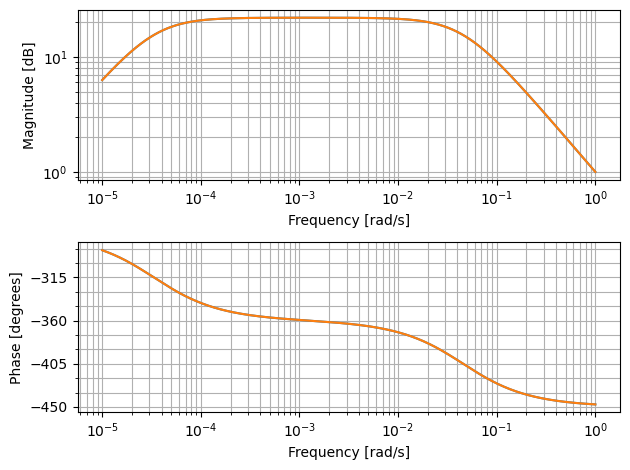

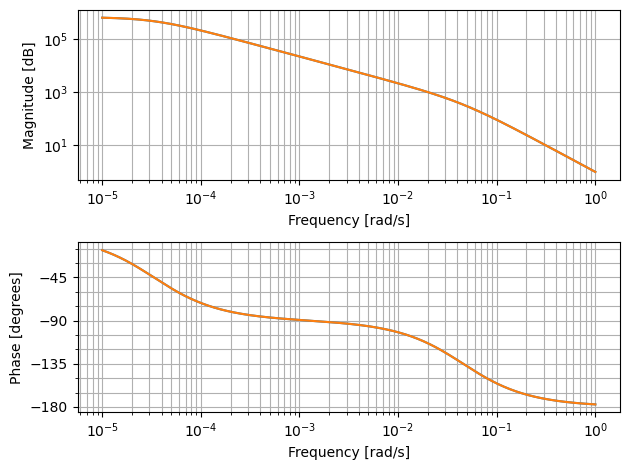

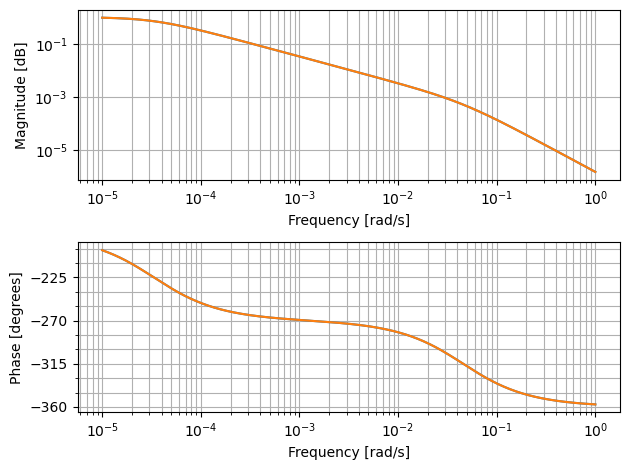

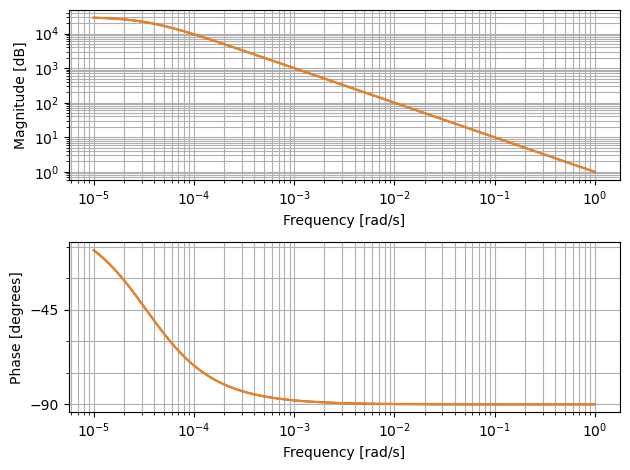

Steady-state Kalman gain:
[[4.55971451e-02]
 [1.52386961e-06]]


In [62]:
import numpy as np
import control as ct
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt

# constants 
c = 2.99792458e8;
L5 = 1176.45e6;
lam5 = c/L5;

# clock noise information
CN0dBHz = -0
CN0 = 10**(CN0dBHz/10)

h0 = 1.5e-22
h0 = h0*20    # *20 w/ vibration
h_2 = 8.5e-32

Sf = h0/2*L5**2
Sg = 2*np.pi**2*h_2*L5**2

# Define system matrices
A = np.array([[0, 1], [0, 0]])  # State transition matrix
B = np.array([[0], [0]])  # Control input matrix
C = np.array([[1, 0]])  # Observation matrix
Q = np.array([[Sf, 0], [0, Sg]])  # Process noise covariance
R = np.array([[1/CN0]])  # Measurement noise covariance

# Compute steady-state covariance matrix
P = solve_continuous_are(A.T, C.T, Q, R)

# Compute steady-state Kalman gain
K_ss = np.dot(P, C.T) / R

s = sympy.symbols('s')
I = sympy.eye(A.shape[0])

# contruct the steady state transfer functions 
T_ss = (s * I - A + K_ss * C).inv()

# Create a list to store the control transfer functions
transfer_functions = []

for row in T_ss: 
    # Extract the numerator and denominator of the transfer function
    numerator, denominator = sympy.fraction(row)

    # Cast numerator and denominator as polynomials
    numerator_poly = sympy.Poly(numerator, s)
    denominator_poly = sympy.Poly(denominator, s)

    # get coefficents of s in format usable for control systems library
    numerator_coeffs = numerator_poly.all_coeffs()
    denominator_coeffs = denominator_poly.all_coeffs()

    # Convert coefficients to lists for control systems library
    numerator_coeffs = [float(coeff) for coeff in numerator_coeffs]
    denominator_coeffs = [float(coeff) for coeff in denominator_coeffs]

    # Print the coefficients
    print("Numerator coefficients:", numerator_coeffs)
    print("Denominator coefficients:", denominator_coeffs)
    print()

    # make transfer funtions 
    tf = ct.TransferFunction(numerator_coeffs, denominator_coeffs)
    poles = ct.pole(tf)

    # append for analysis
    transfer_functions.append(tf)

# Create a new figure for each output channel
for i, tf in enumerate(transfer_functions):
    plt.figure(i + 1)
    
    # Compute the magnitude, phase, and frequency
    mag, phase, omega = ct.bode_plot(tf)

    # Convert phase from radians to degrees
    phase_deg = np.degrees(phase)
    
    # Plot the magnitude response
    plt.subplot(2, 1, 1)
    plt.semilogx(omega, mag)
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(True)
    
    # Plot the phase response
    plt.subplot(2, 1, 2)
    plt.semilogx(omega, phase_deg)
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Phase [degrees]')
    plt.grid(True)
    print("type shape of phase is:", phase.shape)
    plt.tight_layout()
    print("Some sample phase values: \n", phase_deg[0:10])

# Show the plots
plt.show()

print("Steady-state Kalman gain:")
print(K_ss)


In [55]:
print(phase)

[-0.29053927 -0.29371756 -0.29692649 -0.30016622 -0.3034369  -0.30673869
 -0.31007174 -0.3134362  -0.3168322  -0.32025989 -0.3237194  -0.32721085
 -0.33073438 -0.33429009 -0.3378781  -0.34149853 -0.34515146 -0.34883699
 -0.35255522 -0.35630622 -0.36009008 -0.36390685 -0.36775661 -0.3716394
 -0.37555528 -0.37950429 -0.38348645 -0.38750179 -0.39155033 -0.39563206
 -0.399747   -0.40389513 -0.40807643 -0.41229087 -0.4165384  -0.42081899
 -0.42513257 -0.42947908 -0.43385843 -0.43827053 -0.44271529 -0.44719258
 -0.45170229 -0.45624428 -0.46081841 -0.46542452 -0.47006243 -0.47473197
 -0.47943294 -0.48416513 -0.48892833 -0.4937223  -0.4985468  -0.50340157
 -0.50828634 -0.51320082 -0.51814472 -0.52311774 -0.52811954 -0.53314978
 -0.53820813 -0.54329421 -0.54840765 -0.55354806 -0.55871503 -0.56390814
 -0.56912698 -0.57437108 -0.57964    -0.58493326 -0.59025039 -0.59559087
 -0.60095421 -0.60633989 -0.61174736 -0.61717609 -0.62262551 -0.62809505
 -0.63358413 -0.63909215 -0.64461852 -0.65016261 -0.